# 264-1 Using Google Earth Engine and Python to Extract Data and Visualize Imagery


Victoria A. Walker

Tues. 12 Nov, 13:35 - 14:05, Rm 212A

## Initialization

In [1]:
!pip install cartopy geemap xee timezonefinder &> /dev/null # comment out if running in a local env instead of colab

In [2]:
import numpy as np
import pandas as pd
from itertools import compress

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

from timezonefinder import TimezoneFinder
import xarray as xr

import cartopy, geemap, os
from geemap import cartoee
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER

In [3]:
import ee
ee.Authenticate()
ee.Initialize(project="ee-vawalker") # insert your GEE cloud project name here


## Example: Integration with xArray (feat. NLDAS)

1. Select NLDAS data in GEE
2. Import to xArray
3. Resample hourly to daily
4. Chart data

In [18]:
def pull_NLDAS(lat, lon, start, stop, utc_offset):
  """
  Pull hourly NLDAS for a given point.
  Convert time from UTC to local standard.
  """
  # construct EE point
  aoi = ee.Geometry.Point([lon, lat])

  # hourly NLDAS precip filtered by date and AoI
  ic = ee.ImageCollection("NASA/NLDAS/FORA0125_H002") \
         .filterDate(start, stop) \
         .filterBounds(aoi) \
         .map(lambda x: x.clip(aoi)) \
         .select(["total_precipitation"])

  # open in xArray and import geometry
  ds = xr.open_dataset(ic, engine='ee',
                       projection=ic.first().select(0).projection(),
                       geometry=aoi)

  # adjust time from UTC to local standard
  ds["time"] = ds["time"] + utc_offset

  # drop lat, lon since only working with a single point
  ds = ds.squeeze().drop_vars(["lat","lon"])

  return ds

In [19]:
# define site
lat, lon = [45, -92] # [lat, lon] for point
tz = TimezoneFinder().timezone_at(lng=lon, lat=lat)
utc_offset = pd.Timestamp("2000-01-01").tz_localize("UTC") \
               - pd.Timestamp("2000-01-01", tz=tz).tz_convert("UTC")

# define start and end dates
year = 2010
start = pd.Timestamp(f"{str(year)}-01-01 00:00:00", tz=tz).tz_convert("UTC")
stop = pd.Timestamp(f"{str(year)}-12-31 23:00:00", tz=tz).tz_convert("UTC")

# load data into xArray
ds = pull_NLDAS(lat, lon, start, stop, utc_offset)

# convert to pandas for faster resampling (trust me)
df = ds.to_dataframe().resample("1D").sum()

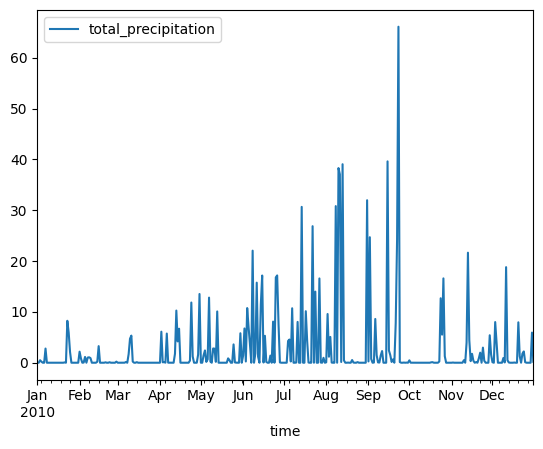

In [20]:
df.plot()
plt.show()

## Example: Publication Quality Maps (feat. NLCD)

1. Select NLCD data in GEE
2. Setup categorical map in cartoee
3. Report landcover within a bounding box

In [4]:
# Select 2021 NLCD layer
nlcd2021 = ee.ImageCollection('USGS/NLCD_RELEASES/2021_REL/NLCD') \
             .filter(ee.Filter.eq('system:index', '2021')).first()
landcover = nlcd2021.select("landcover")

# Define full NLCD legend
nlcd_legend = {
    "11 Open Water": "466b9f",
    "12 Perennial Ice/Snow": "d1def8",
    "21 Developed, Open Space": "dec5c5",
    "22 Developed, Low Intensity": "d99282",
    "23 Developed, Medium Intensity": "eb0000",
    "24 Developed High Intensity": "ab0000",
    "31 Barren Land (Rock/Sand/Clay)": "b3ac9f",
    "41 Deciduous Forest": "68ab5f",
    "42 Evergreen Forest": "1c5f2c",
    "43 Mixed Forest": "b5c58f",
    "51 Dwarf Scrub": "af963c",
    "52 Shrub/Scrub": "ccb879",
    "71 Grassland/Herbaceous": "dfdfc2",
    "72 Sedge/Herbaceous": "d1d182",
    "73 Lichens": "a3cc51",
    "74 Moss": "82ba9e",
    "81 Pasture/Hay": "dcd939",
    "82 Cultivated Crops": "ab6c28",
    "90 Woody Wetlands": "b8d9eb",
    "95 Emergent Herbaceous Wetlands": "6c9fb8"
}

# Define linear palette using NLCD definitions
palette = list(np.tile("000000", 96))
for n in [k[:2] for k in nlcd_legend.keys()]:
  palette[int(n)] = next(v for k,v in nlcd_legend.items() if n in k)

# Define abridged legend (adjust classes as needed)
abridged_legend = {
    "Scrub": "ccb879",
    "Developed": "ab0000",
    "Deciduous Forest": "68ab5f",
    "Evergreen Forest": "1c5f2c",
    "Grassland": "dfdfc2",
    "Pasture/Hay": "dcd939",
    "Cultivated Crops": "ab6c28",
    "Wetlands": "b8d9eb"
}

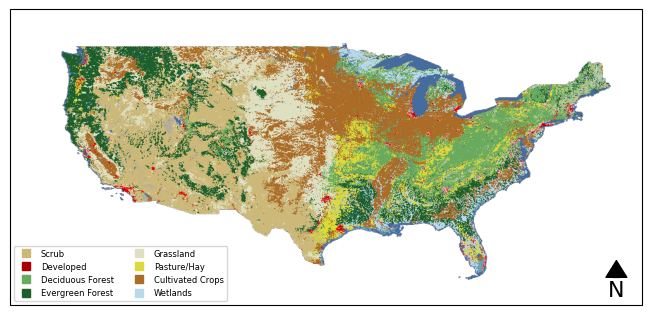

In [5]:
# Set-up figure as a 1-tile mosaic (easy to add more tiles later)
fig, axd = plt.subplot_mosaic([['top']],
                              per_subplot_kw={"top":{"projection":cartopy.crs.PlateCarree()}},
                              layout="constrained")

# Add NLCD landcover to map
cartoee.add_layer(ax = axd["top"], ee_object=landcover,
                  vis_params={'min': 0.0, 'max': 95.0, 'palette': palette})

# Add legend with abridged classes
legend = []
for index, name in enumerate(list(abridged_legend.keys())):
    item = Line2D(
                    [],
                    [],
                    marker="s",
                    color='#' + list(abridged_legend.values())[index],
                    label=name,
                    markerfacecolor='#' + list(abridged_legend.values())[index],
                    markersize=6,
                    ls="",
                )
    legend.append(item)
cartoee.add_legend(axd["top"], legend_elements=legend,
                   font_size=6, loc="lower left", ncol=2)

# Add an arrow pointing North
cartoee.add_north_arrow(
    ax=axd["top"], text="N", xy=(0.96, 0.15), text_color="black", arrow_color="black", fontsize=16)

plt.show()

bbox = [-72.29, 42.34, -71.95, 42.69]


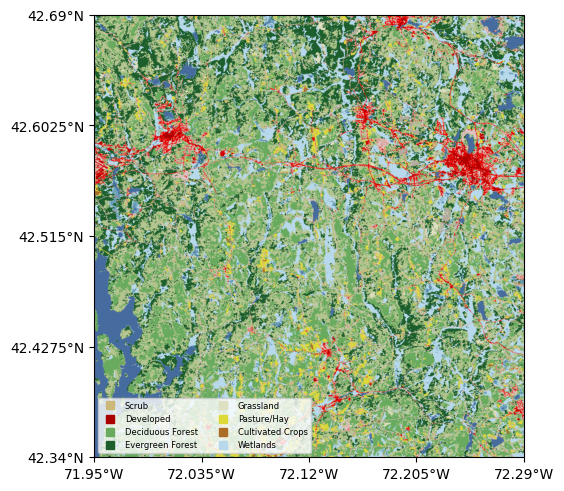

{'11 Open Water': 4.8,
 '21 Developed, Open Space': 0.6,
 '22 Developed, Low Intensity': 0.9,
 '23 Developed, Medium Intensity': 1.7,
 '24 Developed High Intensity': 0.0,
 '31 Barren Land (Rock/Sand/Clay)': 0.3,
 '41 Deciduous Forest': 19.8,
 '42 Evergreen Forest': 19.6,
 '43 Mixed Forest': 36.3,
 '52 Shrub/Scrub': 0.0,
 '71 Grassland/Herbaceous': 0.2,
 '81 Pasture/Hay': 1.7,
 '82 Cultivated Crops': 0.0,
 '90 Woody Wetlands': 13.0,
 '95 Emergent Herbaceous Wetlands': 0.2}

In [17]:
# Define a bounding box
bbox = [-72.29, 42.34, -71.95, 42.69]
print(f"bbox = {bbox}")

# Set-up figure as a 1-tile mosaic (easy to add more tiles later)
fig, axd = plt.subplot_mosaic([['top']],
                              per_subplot_kw={"top":{"projection":cartopy.crs.PlateCarree()}},
                              layout="constrained")

# Add NLCD landcover to map
cartoee.add_layer(ax = axd["top"], ee_object=landcover, region=bbox,
                  vis_params={'min': 0.0, 'max': 95.0, 'palette': palette})

# Add legend with abridged classes
legend = []
for index, name in enumerate(list(abridged_legend.keys())):
    item = Line2D(
                    [],
                    [],
                    marker="s",
                    color='#' + list(abridged_legend.values())[index],
                    label=name,
                    markerfacecolor='#' + list(abridged_legend.values())[index],
                    markersize=6,
                    ls="",
                )
    legend.append(item)
cartoee.add_legend(axd["top"], legend_elements=legend,
                   font_size=6, loc="lower left", ncol=2)

# add tickmarks and labels
xticks = np.linspace(bbox[0], bbox[2] ,5)
yticks = np.linspace(bbox[1], bbox[3],5)
axd["top"].set_xticks(xticks, crs=ccrs.PlateCarree())
axd["top"].set_yticks(yticks, crs=ccrs.PlateCarree())
axd["top"].xaxis.set_major_formatter(LONGITUDE_FORMATTER)
axd["top"].yaxis.set_major_formatter(LATITUDE_FORMATTER)

plt.show()

# Clip NLCD just to bbox
clipped = landcover.clip(ee.Geometry.BBox(*bbox))

# Compute total # of 1-km pixels and counts for each class
pixels = clipped.reduceRegion(reducer=ee.Reducer.count(),scale=1000).getInfo()
counts = clipped.reduceRegion(reducer=ee.Reducer.frequencyHistogram().unweighted(),scale=1000).getInfo()

# Construct dictionary with % of bbox in each class
idxClass = [y in list(counts["landcover"].keys()) for y in[x[:2] for x in list(nlcd_legend.keys())]]
nlcd_bbox = dict(zip(list(compress(list(nlcd_legend.keys()),idxClass)),
                   np.floor(np.array(list(counts["landcover"].values()))/pixels["landcover"]*1000)/10))
nlcd_bbox

## Example: Animations with geemap (feat. NAIP)

1. Select NAIP data in GEE
2. Map a single image in geemap
2. Animate image sequence in geemap

In [21]:
# Randomly select a point and define a buffer zone 500m wide
lat = np.random.uniform(33, 45)
lon = np.random.uniform(-115, -75)
aoi = ee.Geometry.Point([lon, lat]).buffer(500/2).bounds()

# Select NAIP data, filter by dates, clip to AoI, and sort
naip = ee.ImageCollection('USDA/NAIP/DOQQ') \
                 .filterDate("2000-01-01", "2023-12-31") \
                 .filterBounds(aoi) \
                 .sort('system:time_start') \
                 .select(["R","G","B"]) \
                 .map(lambda x: x.clip(aoi))

# Chose a random pass direction and filter image stack to it
index = naip.aggregate_array("system:index")
passDir = index.map(lambda x: ee.String(x).slice(10,12)).distinct().shuffle().get(0)
naip = naip.filter(ee.Filter.stringContains("system:index", passDir))

# Pull a list of image dates
dates = naip.aggregate_array("system:time_start") \
            .map(lambda x: ee.Date(x).format("yyyy-MM-dd"))
dates = pd.to_datetime(dates.getInfo())

# Wrap images in list
images = naip.toList(naip.size())

In [22]:
# Map the first image image
Map = geemap.Map(center=[lat,lon], zoom=16)
image = ee.Image(images.get(int(0)))
Map.addLayer(image, {'bands': ['R', 'G', 'B']}, f'{dates[0].strftime("%Y-%m-%d")}')
Map

Map(center=[43.140623786296246, -94.17893399060107], controls=(WidgetControl(options=['position', 'transparent…

In [24]:
# Animation settings
videoArgs = {
  'dimensions': 400,
  'region': aoi,
  'framesPerSecond': 2,
  'min': 0,
  'max': 255
}

gif = "naip.gif"
geemap.download_ee_video(naip, videoArgs, gif)
geemap.add_text_to_gif(gif, gif, xy=('5%', '5%'), text_sequence=dates[:].strftime("%Y-%m-%d"),
                       font_size=30, font_color='white', duration=1000)
geemap.show_image(gif)

Generating URL...
Please wait ...
The GIF image has been saved to: /content/naip.gif


Output()